## Surge Tank Level Control

In [1]:
import os
import time
import numpy as np
from numpy.testing import assert_array_equal, assert_array_almost_equal
import matplotlib.pyplot as plt
from casadi import (
    SX, MX, DM, Function, Opti, integrator,
    vec, vcat, vertcat, horzcat, sparsify,
    sum1, sum2, sumsqr, sin, cos, norm_2,
    gradient, jacobian, hessian
)

import casadi
casadi.__version__

'3.6.5'

In [2]:
plot_dir = 'plots'
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)

## System Definition

In [3]:
# Physical constants
D = 5  # tank diameter [m]
A = np.pi * D  # tank cross-sectional area [m^2]

# System states: 
#  x[0] : Tank level, L [m]
#  x[1] : Total mass of suspended mineral in tank, m [tons]
nx = 2

# Inputs
#  u[0] : volumetric flowrate into tank, v_dot_in [m^3/hr]
#  u[1] : density of fluid entering tank, rho_in [tons/m^3]
#  u[2] : volumetric flowrate out of tank, v_dot_out [m^3/hr]
nu = 3

In [4]:
# Define the ODE right-hand side
x = MX.sym('x', nx)  
u = MX.sym('u', nu)

dL_dt = (u[0] - u[2]) / A
dm_dt = u[0] * u[1] - u[2] * x[1] / (x[0] * A)

rhs = vertcat(dL_dt, dm_dt)
assert rhs.shape == (nx, 1)

## Create an integrator

In [5]:
# Discrete-time system dynamics
intg_options = {'number_of_finite_elements': 1}

# Runge-Kutta method
solver = 'rk'
dae = {'x': x, 'p': u, 'ode': rhs}
t0 = 0
dt = 0.25
tf = dt / intg_options['number_of_finite_elements']
intg = integrator('intg', solver, dae, t0, tf, intg_options)
print(intg)
res = intg(x0=x, p=u)
x_final = res['xf']

intg:(x0[2],z0[0],p[3],u[0],adj_xf[],adj_zf[],adj_qf[])->(xf[2],zf[0],qf[0],adj_x0[],adj_z0[],adj_p[],adj_u[]) RungeKutta


In [6]:
# Discretized system dynamics
F = Function('F', [x, u], [x_final], ['xk', 'uk'], ['xkp1'])
F

Function(F:(xk[2],uk[3])->(xkp1[2]) MXFunction)

## Simulate system

In [7]:
# Test 1 - no change in volume or concentration
L = 5
conc = 0.2
m = A * L * conc
v_dot_in = 1
v_dot_out = 1

xk = vertcat(L, m)
uk = vertcat(v_dot_in, conc, v_dot_out)
xkp1 = F(xk, uk)
print(xkp1)
assert_array_almost_equal(xkp1, [[L], [m]])

[5, 15.708]


In [8]:
# Test 2 - increasing volume
L = 5
conc = 0.2
m = A * L * conc
v_dot_in = 2
v_dot_out = 1

xk = vertcat(L, m)
uk = vertcat(v_dot_in, conc, v_dot_out)
xkp1 = F(xk, uk)
L2 = L + (v_dot_in - v_dot_out) * dt / A
m2 = (A * L + (v_dot_in - v_dot_out) * dt) * conc
print(xkp1)
assert_array_almost_equal(xkp1, [[L2], [m2]])

[5.01592, 15.758]


In [9]:
# Test 3 - increasing concentration with no out flow
L = 5
conc = 0.2
m = A * L * conc
v_dot_in = 1
conc_in = 2 * conc
v_dot_out = 0

xk = vertcat(L, m)
uk = vertcat(v_dot_in, conc_in, v_dot_out)
xkp1 = F(xk, uk)
L2 = L + (v_dot_in - v_dot_out) * dt / A
m2 = (A * L * conc + (v_dot_in * dt) * conc_in)
print(xkp1)
assert_array_almost_equal(xkp1, [[L2], [m2]])

[5.01592, 15.808]


In [10]:
# Test 4 - response with zero initial concentration in tank
L = 5
m = 0
v_dot_in = 1
conc_in = 0.5
v_dot_out = 1

xk = vertcat(L, m)
uk = vertcat(v_dot_in, conc_in, v_dot_out)
N = 1000
X = np.full((N+1, 2), np.nan)
for k in range(N+1):
    xk = F(xk, uk)
    X[k, :] = xk.T
m_final = A * L * conc_in
print(xk)
assert_array_almost_equal(xk, [[L], [37.64707001]])

[5, 37.6471]


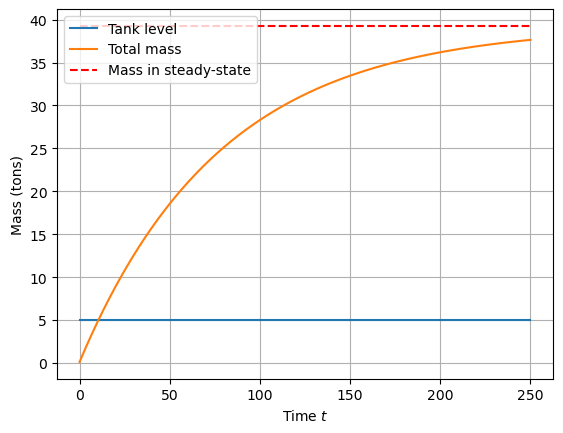

In [11]:
t = dt * np.arange(0, N+1)
plt.plot(t, X)
plt.hlines(m_final, t[0], t[-1], color='r', linestyle='--')
plt.grid()
plt.xlabel('Time $t$')
plt.ylabel(r'Mass (tons)')
plt.legend(labels=['Tank level', 'Total mass', 'Mass in steady-state'], loc='best')
plt.show()

In [12]:
# Test 5 - response with initial mass and zero inlet concentration in tank
L = 5
m = 39.2699
v_dot_in = 1
conc_in = 0
v_dot_out = 1

xk = vertcat(L, m)
uk = vertcat(v_dot_in, conc_in, v_dot_out)
N = 1000
X = np.full((N+1, 2), np.nan)
for k in range(N+1):
    xk = F(xk, uk)
    X[k, :] = xk.T
m_final = A * L * conc_in
print(xk)
assert_array_almost_equal(xk, [[L], [1.6228378263937633]])

[5, 1.62284]


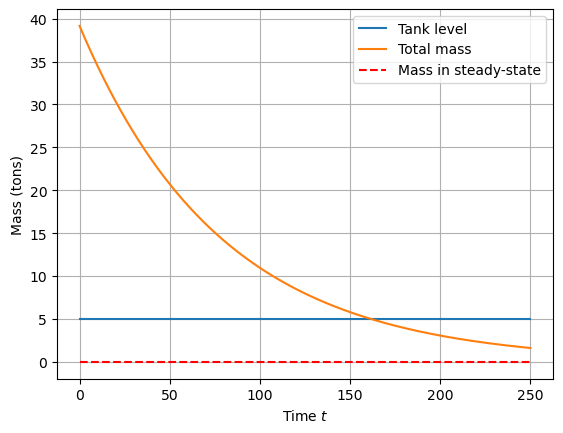

In [13]:
t = dt * np.arange(0, N+1)
plt.plot(t, X)
plt.hlines(m_final, t[0], t[-1], color='r', linestyle='--')
plt.grid()
plt.xlabel('Time $t$')
plt.ylabel(r'Mass (tons)')
plt.legend(labels=['Tank level', 'Total mass', 'Mass in steady-state'], loc='best')
plt.show()

In [14]:
# Test 6 - response with initial mass and zero inlet concentration in tank
L = 5
m = 25
v_dot_in = 1.5
conc_in = 0.1
v_dot_out = 1

xk = vertcat(L, m)
uk = vertcat(v_dot_in, conc_in, v_dot_out)
N = 1000
X = np.full((N+1, 2), np.nan)
for k in range(N+1):
    xk = F(xk, uk)
    X[k, :] = xk.T
print(xk)
#assert_array_almost_equal(xk, [[L], [37.64707001]])

[12.9657, 22.9163]


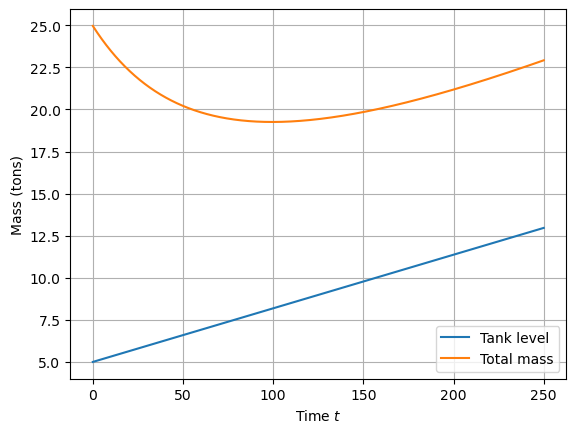

In [15]:
t = dt * np.arange(N+1)
plt.plot(t, X)
plt.grid()
plt.xlabel('Time $t$')
plt.ylabel(r'Mass (tons)')
plt.legend(labels=['Tank level', 'Total mass'], loc='best')
plt.show()

## Analytical solution found using sympy

See this stackoverflow post:
 - https://stackoverflow.com/q/78312841/1609514

In [16]:
def ivp_solution(t, x1_init, x2_init, u1, u2, u3, A):
    if u1 == u3:
        return [
            x1_init,
            u2 - (u2 - x2_init) * np.exp(-t * u1 / (A * x1_init))
        ]
    return [
        x1_init + t*(u1 - u3)/A,
        u2*(A*x1_init + t*u1 - t*u3) + ((A*x1_init)**(u3/(u1 - u3))*x2_init - u2*np.exp(u1*np.log(A*x1_init)/(u1 - u3)))*np.exp(-u3*np.log(A*x1_init + t*u1 - t*u3)/(u1 - u3))
    ]

# Test with same parameters as in Example 6 above
L = 5
m = 25
v_dot_in = 1.5
conc_in = 0.1
v_dot_out = 1
assert ivp_solution(0.25, L, m, v_dot_in, conc_in, v_dot_out, A) \
    == [5.007957747154594, 24.958052546626035]
v_dot_in = v_dot_out
assert ivp_solution(0.25, L, m, v_dot_in, conc_in, v_dot_out, A) \
    == [5, 24.920866849476447]

In [17]:
def ivp_solution2(t, x1_init, x2_init, u1, u2, u3, A):
    u1mu3 = u1 - u3
    if u1mu3 == 0:
        return [
            x1_init,
            u2 - (u2 - x2_init) * np.exp(-t * u1 / (A * x1_init))
        ]
    Ax1initptu1mu3 = A * x1_init + t * u1mu3
    return [
        Ax1initptu1mu3 / A,
        u2 * Ax1initptu1mu3
        + (
            (A * x1_init) ** (u3 / u1mu3) * x2_init 
            - u2 * np.exp(u1 * np.log(A * x1_init) / u1mu3)
        ) * np.exp(-u3 * np.log(Ax1initptu1mu3) / u1mu3)
    ]

# Test with same parameters as in Example 6 above
L = 5
m = 25
v_dot_in = 1.5
conc_in = 0.1
v_dot_out = 1
assert ivp_solution2(0.25, L, m, v_dot_in, conc_in, v_dot_out, A) \
    == [5.007957747154595, 24.958052546626035]
v_dot_in = v_dot_out
assert ivp_solution2(0.25, L, m, v_dot_in, conc_in, v_dot_out, A) \
    == [5, 24.920866849476447]

In [18]:
# Test 6 - response with initial mass and zero inlet concentration in tank
L = 5
m = 25
v_dot_in = 1.5
conc_in = 0.1
v_dot_out = 1

x0 = np.array([L, m])
uk = np.array([v_dot_in, conc_in, v_dot_out])
N = 1000
X_anal = np.full((N+1, 2), np.nan)
for k, t in enumerate(dt * np.arange(N+1)):
    xk = np.array(ivp_solution(t, x0[0], x0[1], uk[0], uk[1], uk[2], A))
    X_anal[k, :] = xk
print(xk)

[12.95774715 22.90694328]


Compare analytical solution to RK4 approximation

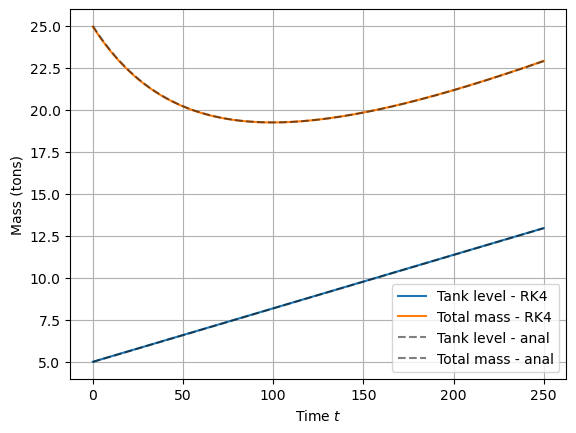

In [19]:
t = dt * np.arange(N+1)
plt.plot(t, X[:, 0], label='Tank level - RK4')
plt.plot(t, X[:, 1], label='Total mass - RK4')
plt.plot(t, X_anal[:, 0], linestyle='--', label='Tank level - anal', color='k', alpha=0.5)
plt.plot(t, X_anal[:, 1], linestyle='--', label='Total mass - anal', color='k', alpha=0.5)
plt.grid()
plt.xlabel('Time $t$')
plt.ylabel(r'Mass (tons)')
plt.legend(loc='best')
plt.show()

In [20]:
assert np.max(X - X_anal) < 0.01

## One-Tank System

### Set up optimal control problem – mutliple shooting

In [74]:
opti = casadi.Opti()

dt = 0.25  # length of 1 control interval [hrs]
T = 24  # control horizon [hrs]
N = int(np.ceil(T / dt))  # Number of control intervals

# Physical constants
D = 5  # tank diameter [m]
A = DM(np.pi * D)  # tank cross-sectional area [m^2]

nx = 2  # number of states
nu = 2  # number of manipulated variables (MVs)
ny = 1  # number of controlled variables (CVs)

# State variables
X = opti.variable(N+1, nx)

# Control variables
U = opti.variable(N, nu)

# Aliases for states
L1 = X[:, 0]  # Tank level [m]
m1 = X[:, 1]  # Total mass of suspended mineral [tons]

# Aliases for manipulated variables
dvdt01 = U[:, 0]  # Flowrate into tank [m^3/hr]
c01 = U[:, 1]  # Concentration of tank inflow [tons/m^3]

# Assume constant outflow
D = MX.ones(N+1)

# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[k+1, :] == F(X[k, :].T, vertcat(U[k, :].T, D[k])).T)

# Path constraints
opti.subject_to(opti.bounded(0, L1, 10))

# Initial constraint
opti.subject_to(X[0, :] == horzcat(5, 25))

# Output variables
c1 = m1 * (A * L1)

# Objective: reference tracking
c_ref = DM(0.5)
opti.minimize(sumsqr(c_ref - c1))
opti

Opti(Opti {
  instance #16
  #variables: 2 (nx = 386)
  #parameters: 0 (np = 0)
  #constraints: 98 (ng = 291)
  CasADi solver needs updating.
})

In [73]:
# solve optimization problem
opti.solver('ipopt')

sol = opti.solve()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      770
Number of nonzeros in inequality constraint Jacobian.:       97
Number of nonzeros in Lagrangian Hessian.............:      771

Error evaluating Jacobian of equality constraints at user provided starting point.
  No scaling factors for equality constraints computed!
Error evaluating Jacobian of inequality constraints at user provided starting point.
  No scaling factors for inequality constraints computed!

Number of Iterations....: 0

Number of objective function evaluat

CasADi - 2024-04-11 18:29:14 WARNING("intg:step failed: NaN detected for output xf, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-04-11 18:29:14 WARNING("intg:step failed: NaN detected for output xf, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-04-11 18:29:14 WARNING("intg:step failed: NaN detected for output xf, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-04-11 18:29:14 WARNING("intg:step failed: NaN detected for output xf, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-04-11 18:29:14 WARNING("intg:step failed: NaN detected for output xf, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-04-11 18:29:14 WARNING("intg:step failed: NaN detected for output xf, at (row 1, col 0).") [.../casadi/core/oracle_function.cpp:377]
CasADi - 2024-04-11 18:29:14 WARNING("intg:step failed: NaN detected for output xf, at (row 1, col 0).") [.../casadi/c

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
.../casadi/core/optistack_internal.cpp:998: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Invalid_Number_Detected'

## Four-Tank System

### Set up optimal control problem – mutliple shooting

In [23]:
opti = casadi.Opti()

dt = 0.25  # length of 1 control interval [hrs]
T = 24  # control horizon [hrs]
N = int(np.ceil(T / dt))  # Number of control intervals

nx = 12
nu = 4

# Decision variables for states
X = opti.variable(nx, N+1)

# Decision variables for control actions
U = opti.variable(N, nu)  # force [N]

# Aliases for states
L1 = X[0, :]  # Tank 1 level [m]
L2 = X[1, :]  # Tank 2 level [m]
L3 = X[2, :]  # Tank 3 level [m]
L4 = X[3, :]  # Tank 4 level [m]
m1 = X[5, :]  # Total mass of suspended mineral in tank 1 [tons]
m2 = X[5, :]  # Total mass of suspended mineral in tank 2 [tons]
m3 = X[5, :]  # Total mass of suspended mineral in tank 3 [tons]
m4 = X[5, :]  # Total mass of suspended mineral in tank 4 [tons]

# Aliases for manipulated variables
dvdt12 = U[0, :]  # Flowrate from tank 1 to tank 2 [m^3/hr]
dvdt13 = U[1, :]  # Flowrate from tank 1 to tank 3 [m^3/hr]
dvdt24 = U[0, :]  # Flowrate from tank 2 to tank 4 [m^3/hr]
dvdt34 = U[1, :]  # Flowrate from tank 3 to tank 4 [m^3/hr]

In [24]:
k = 0
opti.subject_to(X[:, k+1] == F(X[:, k], U[k]))

Function(F:(xk[2],uk[3])->(xkp1[2]) MXFunction)

In [22]:


# Gap-closing shooting constraints
for k in range(N):
    opti.subject_to(X[:, k+1] == F(X[:,k],U[k]))

# Path constraints
opti.subject_to(opti.bounded(-3,  pos, 3)) # Syntax -3 <= pos <= 3 not supported in Python
opti.subject_to(opti.bounded(-1.2, U, 1.2))

# Initial and terminal constraints
opti.subject_to(X[:, 0] == vertcat(1, 0, 0, 0))
opti.subject_to(X[:, -1] == vertcat(0, 0, 0, 0))

# Objective: regularization of controls
opti.minimize(sumsqr(U))

# solve optimization problem
opti.solver('ipopt')

sol = opti.solve()

NameError: name 'pos' is not defined